# core

> Fill in a module description here

In [ ]:
#| default_exp preprocessing

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
#| export
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from pathlib import Path
from functools import partial
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import os
import albumentations as A
import random
import cv2
from fastcore.basics import patch
from fastcore.all import *
#from fastai.vision.all import *
from dataclasses import dataclass, field

from typing import Union, List, Tuple, Optional, Callable, Dict, Any

2023-04-18 10:54:40.702106: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-18 10:54:40.813404: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [ ]:
#| hide
mpl.rcParams['image.cmap'] = 'gray'

In [ ]:
#| export
IMAGE_HEIGHT = 224
IMAGE_WIDTH = 224
EPOCS = 5
BATCH_SIZE = 8
BUFFER_SIZE = 30
class_names = ['Pin']
train_count = 107
test_count = 27
num_classes = len(class_names)
steps_per_epoch = train_count // BATCH_SIZE
validation_steps = test_count // BATCH_SIZE


In [ ]:
#| hide
from nbdev.showdoc import *

In [ ]:

path = Path(r'/home/goni/workspace/projects/easy_pin_detection/data_first/Trainingsdata_1024_1224')
path.ls()


(#3) [Path('/home/goni/workspace/projects/easy_pin_detection/data_first/Trainingsdata_1024_1224/models'),Path('/home/goni/workspace/projects/easy_pin_detection/data_first/Trainingsdata_1024_1224/X'),Path('/home/goni/workspace/projects/easy_pin_detection/data_first/Trainingsdata_1024_1224/y')]

In [ ]:
#| export
@dataclass
class Preprocess:
    image_path:Union[Path, str]
    label_path:Union[Path, str]
    im_height:int = IMAGE_HEIGHT
    im_width:int = IMAGE_WIDTH
    bf_size:int = BUFFER_SIZE
    bs:int = BATCH_SIZE
    one_channel:bool=False
    test_size:float = 0.2
    img_ext:str = field(default_factory=str, init=False, repr=True)

    def __post_init__(self):
        self.img_ext = Path(self.image_path).ls()[0].suffix
        pat = f'*{self.img_ext}'
        self.images = [str(i) for i in Path(self.image_path).rglob(pat)]
        self.labels = [str(i) for i in Path(self.label_path).rglob(pat)]
        self.train_images, self.test_images, \
            self.train_labels, self.test_labels = train_test_split(
                         self.images,
                         self.labels, 
                         test_size=self.test_size,
                         random_state=42)


In [ ]:
preprocess_obj = Preprocess(
                           image_path=path/'X',
                           label_path=path/'y',
                           im_height=IMAGE_HEIGHT,
                           im_width=IMAGE_WIDTH,
                           bs=BATCH_SIZE,
                           one_channel=False,
                           test_size=0.2
                           )

> Augmentation needs to be done before resizing the image
- - - - - - - - - - - - - - - - -

In [ ]:
#| export
@patch_to(Preprocess)
def show_image(self,im_file):
    #image = self.from_file_to_image(im_file)
    plt.imshow(im_file)
    plt.axis('off')
    plt.show()

In [ ]:
#| export
@patch_to(Preprocess)
def read_image(self,im_file, one_channel=False):
    if one_channel:
        im = tf.io.read_file(im_file)
        im = tf.image.decode_png(im, channels=1)
    else:
        im = tf.io.read_file(im_file)
        im = tf.image.decode_png(im, channels=3)
    return im

In [ ]:
#| hide
# testing one channel function

In [ ]:
fn =str((path/'X').ls()[0])
fn_lbl = str((path/'y').ls()[0])
img_ = preprocess_obj.read_image(fn, one_channel=True)
test_eq(img_.numpy().shape, (1024, 1224, 1))
img_ = preprocess_obj.read_image(fn, one_channel=False)
lbl_ = preprocess_obj.read_image(fn_lbl, one_channel=False)
test_eq(img_.numpy().shape, (1024, 1224, 3))

2023-04-18 10:54:58.979576: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-04-18 10:54:58.996838: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-04-18 10:54:58.997556: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-04-18 10:54:58.999003: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FM

In [ ]:
#| export
@patch_to(Preprocess)
def augmentation_(
        self,
        im_height:int,
        im_width:int,
        image:tf.Tensor,
        mask:tf.Tensor,
        ):
    aug = A.Compose([
    A.OneOf([
        A.RandomSizedCrop(min_max_height=(250, 250), height=im_height, width=im_width, p=0.5),
        A.PadIfNeeded(
                      #min_height=im_height,
                     # min_width=im_width,
                        p=0.5)
    ], p=1),    
    A.HorizontalFlip(p=0.5),              
    A.VerticalFlip(p=0.5),              
    A.RandomRotate90(p=0.5),
    A.Transpose(p=0.5),
    A.OneOf([
        A.ElasticTransform(alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03, p=0.5),
        A.GridDistortion(p=0.5),
        A.OpticalDistortion(distort_limit=2, shift_limit=0.5, p=1)                  
        ], p=0.8),
    #A.CLAHE(p=0.8),
    A.RandomBrightnessContrast(p=0.8),    
    A.RandomGamma(p=0.8)])
    aug_data = aug(image=image.numpy(), mask=mask.numpy())
    image, mask = aug_data['image'], aug_data['mask']
    #mask = tf.expand_dims(mask, axis=-1)
    return image, mask

In [ ]:
#| export
@patch_to(Preprocess)
def show_aug(
    self,
    image,
    mask,
    original_image=None,
    original_mask=None
    ):
    
    fontsize = 18
    
    if original_image is None and original_mask is None:
        f, ax = plt.subplots(2, 1, figsize=(8, 8))

        ax[0].imshow(image)
        ax[1].imshow(mask)
    else:
        f, ax = plt.subplots(2, 2, figsize=(8, 8))

        ax[0, 0].imshow(original_image)
        ax[0, 0].set_title('Original image', fontsize=fontsize)
        ax[0, 0].axis('off')
        
        ax[1, 0].imshow(original_mask)
        ax[1, 0].set_title('Original mask', fontsize=fontsize)
        ax[1, 0].axis('off')
        
        ax[0, 1].imshow(image)
        ax[0, 1].set_title('Transformed image', fontsize=fontsize)
        ax[0, 1].axis('off')

        
        ax[1, 1].imshow(mask)
        ax[1, 1].set_title('Transformed mask', fontsize=fontsize)
        ax[1, 1].axis('off')
    f.tight_layout()

In [ ]:
#| export
@patch_to(Preprocess)
def read_aug(
            self,
            im_file:str,
            lbl_file:str,
            one_channel:bool=False, 
            aug:bool=False):
    img = self.read_image(im_file=im_file, one_channel=one_channel)
    mask = self.read_image(im_file=lbl_file, one_channel=one_channel)
    if aug:
        return self.augmentation_(im_height=img.shape[1], im_width=img.shape[0], image=img, mask=mask)
    else:
        return img, mask

In [ ]:
im, msk = preprocess_obj.read_aug(im_file=fn, lbl_file=fn_lbl, one_channel=False, aug=True)
im.shape, msk.shape
test_eq_type(type(im), np.ndarray), test_eq_type(type(msk), np.ndarray);

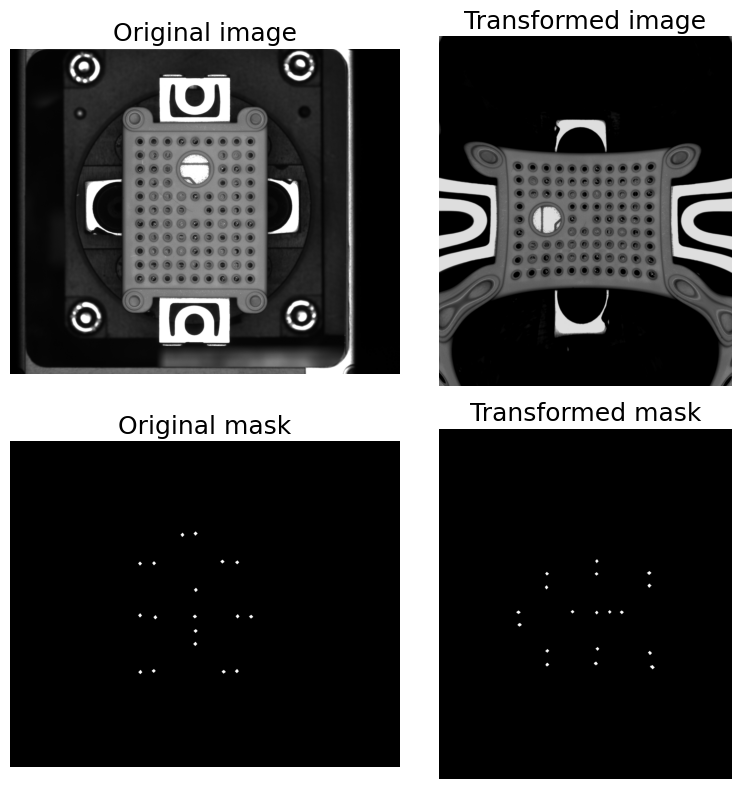

In [ ]:
preprocess_obj.show_aug(image=im, mask=msk, original_image=img_.numpy(), original_mask=lbl_.numpy())

In [ ]:
#| export
@ patch_to(Preprocess)
def normalize(
              self,
              image:Union[np.ndarray, tf.Tensor], 
              min=0):
    def _normalize(im):
        img = tf.cast(im, tf.float32)
        return img / 255.0

    if min == 0:
        return _normalize(image)
    else:
        return (_normalize(image) * 2.0) -1.0

In [ ]:
im.shape

(1224, 1024, 3)

In [ ]:
norm_img = preprocess_obj.normalize(im)
np_img_ = norm_img.numpy()
np_img_.min(), im.min(), np_img_.max(), im.max()
#test_eq(np_img_.min(),0.0), test_eq(np_img_.max(),1.0);

(0.0, 0, 0.87058824, 222)

In [ ]:
#| export
@ patch_to(Preprocess)
def process_image_and_mask(
                       self,
                       im_file:str,
                       lbl_file:str,
                       norm:bool=True,
                       one_channel:bool=False,
                       aug_data:bool=True
                       ):
    image,mask = self.read_aug(im_file, lbl_file, one_channel=one_channel, aug=aug_data)
    image, mask = tf.image.resize(image, (self.im_height, self.im_width)), tf.image.resize(mask, (self.im_height, self.im_width))
    if norm:
        image = self.normalize(image)
        mask = self.normalize(mask)
    if one_channel:
        image = tf.reshape(image, (self.im_height, self.im_width, 1,))
        mask = tf.reshape(mask, (self.im_height, self.im_width, 1,))
    else:
        image = tf.reshape(image, (self.im_height, self.im_width, 3,))
        mask = tf.reshape(mask, (self.im_height, self.im_width, 3,))
    return image,mask

In [ ]:
im, msk = preprocess_obj.process_image_and_mask(im_file=fn, lbl_file=fn_lbl, norm=True, one_channel=False)

In [ ]:
type(im),  type(msk)

(tensorflow.python.framework.ops.EagerTensor,
 tensorflow.python.framework.ops.EagerTensor)

In [ ]:
test_eq(im.numpy().shape, (IMAGE_HEIGHT,IMAGE_WIDTH,3))
test_eq(msk.numpy().shape, (IMAGE_HEIGHT,IMAGE_WIDTH,3))

# Create dataset

In [ ]:
#| export
@ patch_to(Preprocess)
def process_data(
                 self,
                 image,
                 label,
                 norm:bool=True,
                 one_channel:bool=False,
                 aug_data:bool=True):
    #@tf.function
    aug_img, aug_lbl = tf.numpy_function(func=self.process_image_and_mask, inp=[image, label, norm, one_channel, aug_data], Tout=(tf.float32, tf.float32))
    return aug_img, aug_lbl

In [ ]:
#| export
@patch_to(Preprocess)
def set_shapes(
              self,
              img, 
              label, 
              img_shape):
    img.set_shape(img_shape)
    label.set_shape(img_shape)
    return img, label

In [ ]:
#| export
@patch_to(Preprocess)
def create_dataset(
                  self,
                  images, labels,
                  train:bool=True,
                  norm:bool=True,
                  aug:bool=True
                  ):
    _dataset = tf.data.Dataset.from_tensor_slices((images, labels))
    _dataset = _dataset.map(partial(self.process_data, aug_data=aug, norm=norm), num_parallel_calls=tf.data.AUTOTUNE)
    
    if self.one_channel:
        _dataset = _dataset.map(partial(self.set_shapes, img_shape=(self.im_height, self.im_width, 1)), num_parallel_calls=tf.data.AUTOTUNE)
    else:
        _dataset = _dataset.map(partial(self.set_shapes, img_shape=(self.im_height, self.im_width, 3)), num_parallel_calls=tf.data.AUTOTUNE)
    if train:
        return  _dataset\
                   .cache()\
                   .shuffle(
                            self.bf_size,
                            reshuffle_each_iteration=True)\
                   .batch(self.bs)\
                   .repeat()\
                   .prefetch(buffer_size=tf.data.AUTOTUNE)
    else:
        #_dataset = _dataset.map(self.process_image_and_mask, num_parallel_calls=tf.data.AUTOTUNE)
        return  _dataset.batch(self.bs).repeat()


In [ ]:
#| export
@patch_to(Preprocess)
def create_train_test_dataset(self):
    self.train_dataset = self.create_dataset(
                                            images=self.train_images, 
                                            labels=self.train_labels,
                                            norm=True,
                                            aug=True,
                                            train=True)
    self.test_dataset = self.create_dataset(
                                           images=self.test_images,
                                           labels=self.test_labels,
                                           norm=True,
                                           aug=False,
                                           train=False)
    return self.train_dataset, self.test_dataset

In [ ]:
#| hide
train_ds, test_ds = preprocess_obj.create_train_test_dataset()

In [ ]:
#| hide
train_ds.take(1), test_ds.take(1)

(<TakeDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None))>,
 <TakeDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None))>)

In [ ]:
one_batch = next(iter(train_ds))

2023-04-18 10:55:42.416394: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [ ]:
images_ds, masks_ds = one_batch

In [ ]:
#| export
def convert_np_and_uint8(img:tf.Tensor)->Tuple[np.array, np.array]:
    "Convert img to np.array and uint8"

    if isinstance(img, tf.data.Dataset) or isinstance(img, tf.Tensor):
        m_scale1=img.numpy()
        m_scale255=(img * 255).numpy().astype(np.uint8)
    elif isinstance(img, np.ndarray):
            
        if img.dtype in [np.float16, np.float32, np.float64]:
            m_scale255 = (img * 255).astype(np.uint8)
            m_scale1 = img
            raise Exception("unknown dtype:", img.dtype)

    return m_scale1, m_scale255

In [ ]:
#| export
def convert_one_channel(img:tf.Tensor):
    "Convert image to one channel"
    img = tf.image.rgb_to_grayscale(img)
    img = tf.reshape(img, (IMAGE_HEIGHT, IMAGE_WIDTH, 1))
    return img

In [ ]:
#| export
@patch_to(Preprocess)
def create_color_mask(
             self,
             mask:Union[np.array, tf.Tensor], 
             img:Union[np.array, tf.Tensor],
             threshold:float=0.5):
    "Creating color mask for segmentation"
    overlay_mask = np.ones((self.im_height, self.im_width, 3,), dtype=np.uint8)
    overlay_mask[:, :, 0] = img.reshape(*(self.im_height, self.im_width))
    overlay_mask[:, :, 1] = img.reshape(*(self.im_height, self.im_width))
    overlay_mask[:, :, 2] = img.reshape(*(self.im_height, self.im_width))
    match = mask.reshape(*(self.im_height, self.im_width)) > (threshold * 255)
    overlay_mask[match] = [0,255,0]
    return overlay_mask

In [ ]:
#| export
@patch_to(Preprocess)
def display_np_batch(
                    self,
                    images:np.ndarray,
                    masks:np.ndarray,
                    threshold:float=0.5):
    "Displaying batch of images and masks"
    n_batch = images.shape[0]
    for i in range(n_batch):
        if images[i].shape[2] ==3:
            img = images[i][:,:,0]
            mask = masks[i][:,:,0]
        else:
            img = images[i].reshape(self.im_height, self.im_width )
            mask = masks[i].reshape(self.im_height, self.im_width )
        
        _, ax = plt.subplots(1, 3, figsize=(15, 10)) 
        ax[0].imshow(img, cmap='gray')
        ax[0].axis('off')
        ax[0].set_title('only image')
        clr_mask_ = self.create_color_mask(mask=mask, img=img, threshold=threshold)
        ax[1].imshow(mask)
        ax[1].axis('off')
        ax[1].set_title('only mask')
        ax[2].imshow(clr_mask_)
        ax[2].axis('off')
        ax[2].set_title('image with mask')
        plt.tight_layout()

In [ ]:
#| export
@patch_to(Preprocess)
def display_ds(self,
            ds:tf.data.Dataset):

    images, masks = next(iter(ds))

    # convert to numpy and uint8 and getting scaled(255) image and mask
    images_np, images_255_np = convert_np_and_uint8(images)
    masks_np, masks_255_np = convert_np_and_uint8(masks)
    self.display_np_batch(
                          images=images_255_np,
                          masks=masks_255_np, 
                          threshold=0.5)

    

2023-04-18 10:56:07.311690: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


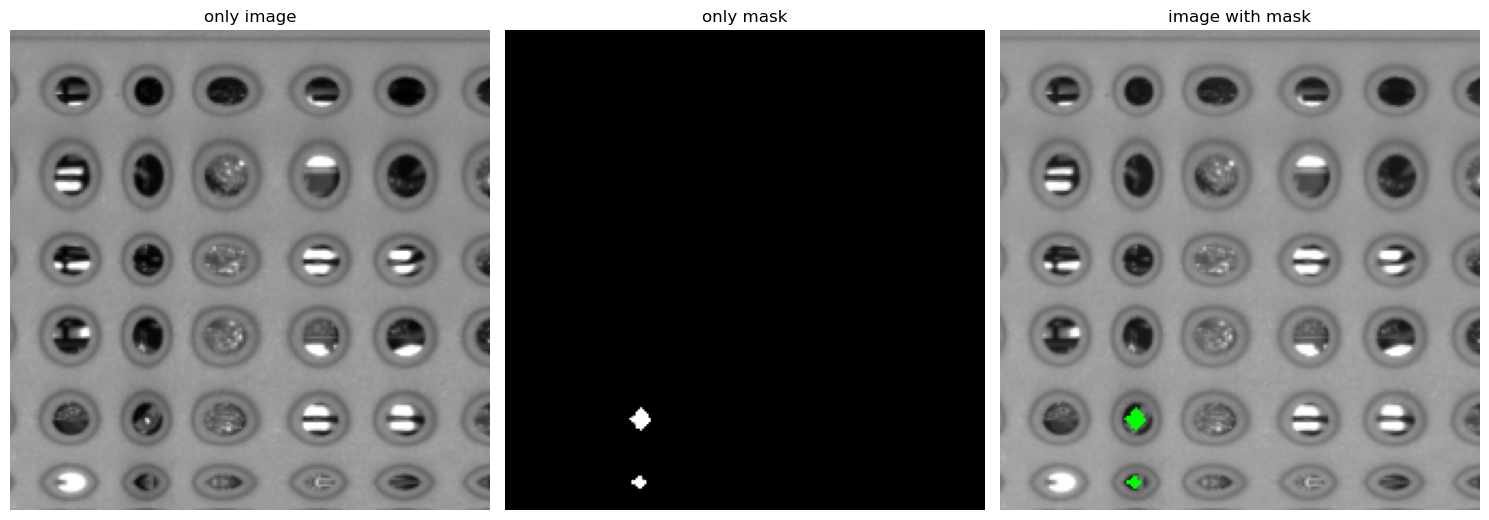

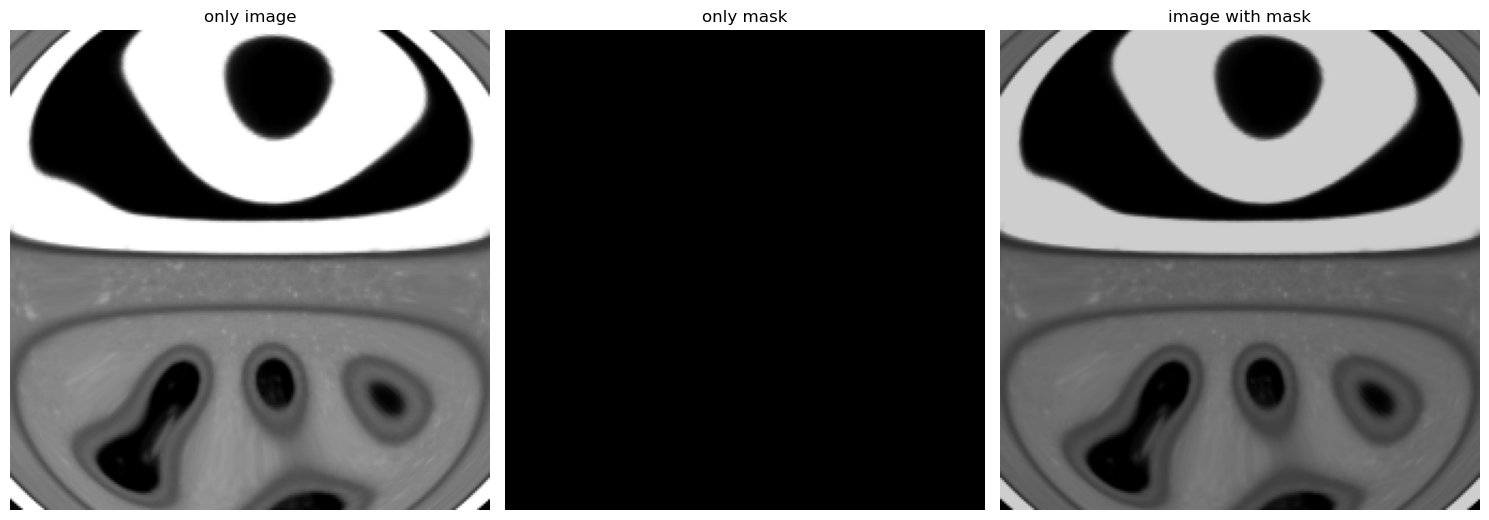

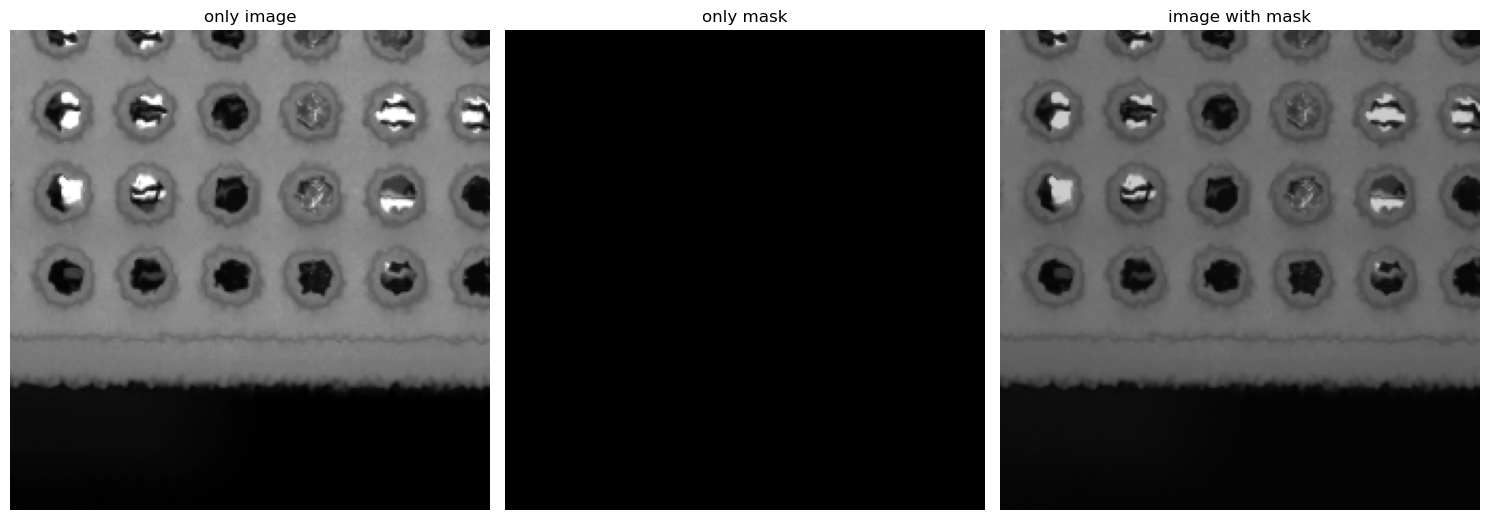

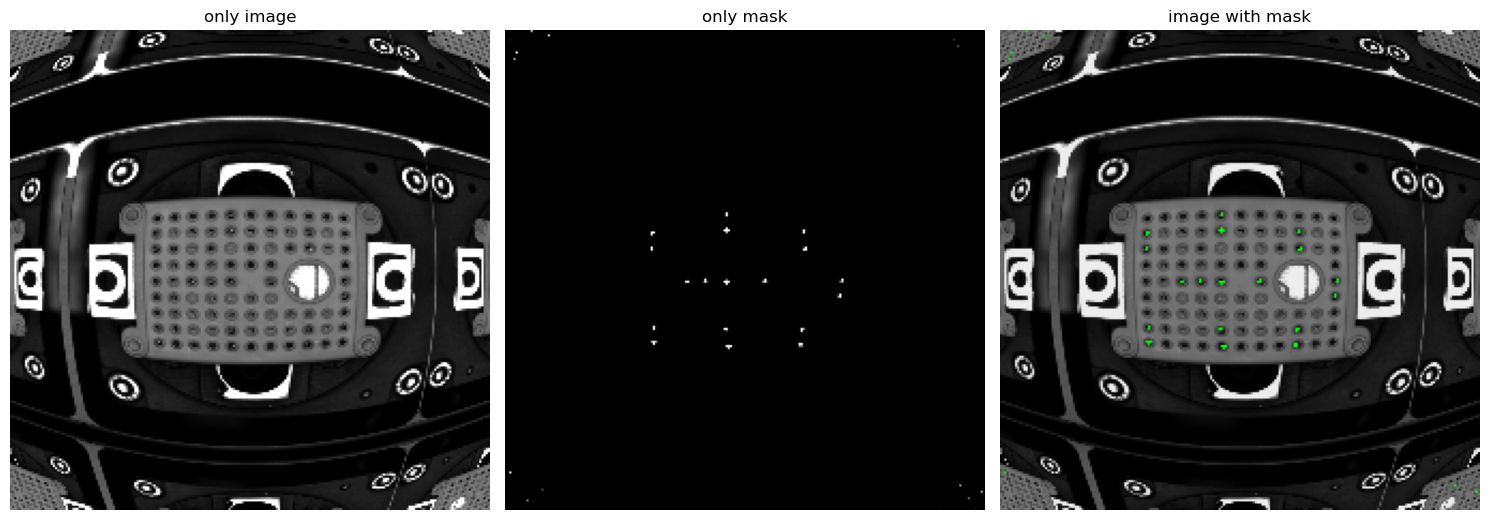

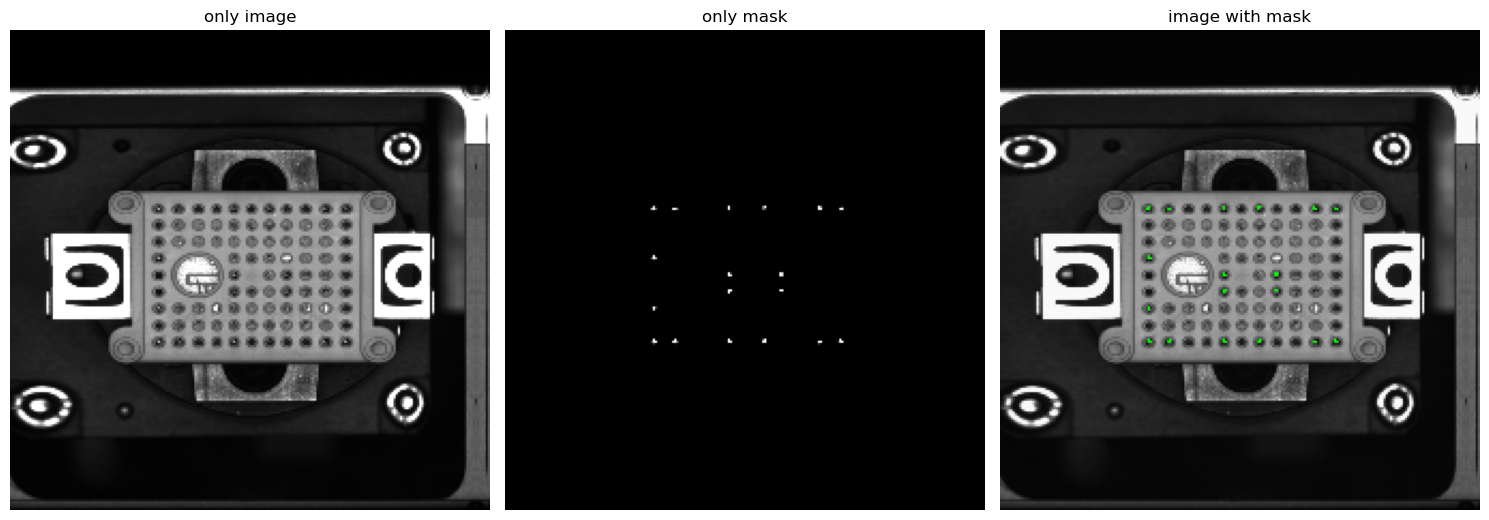

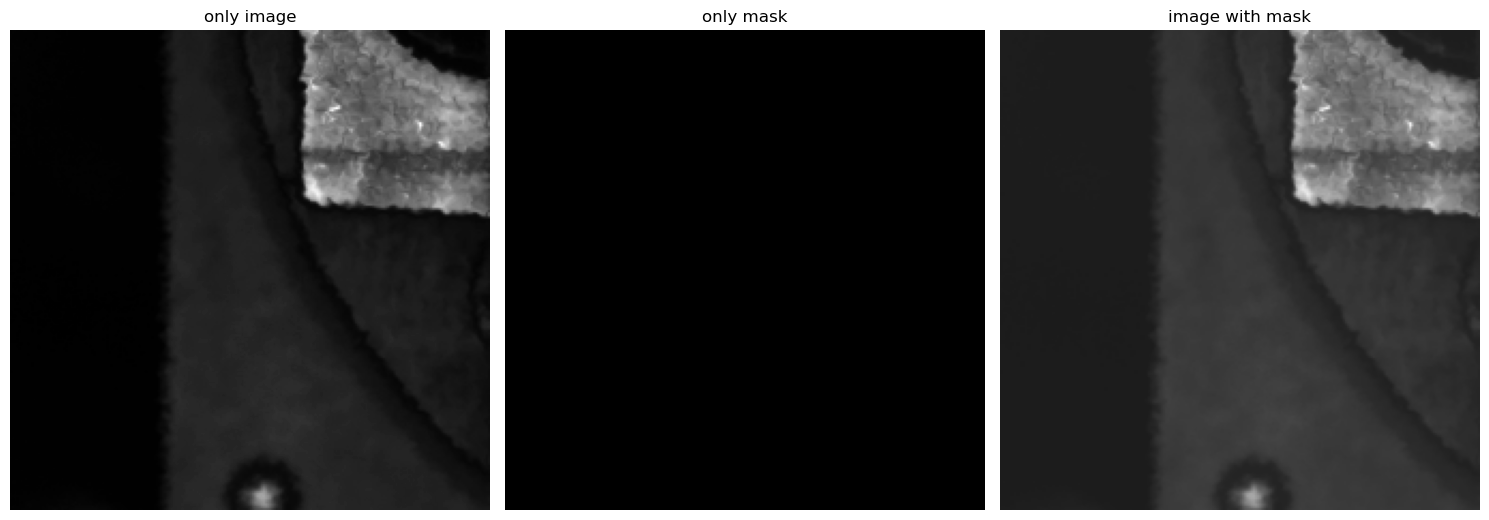

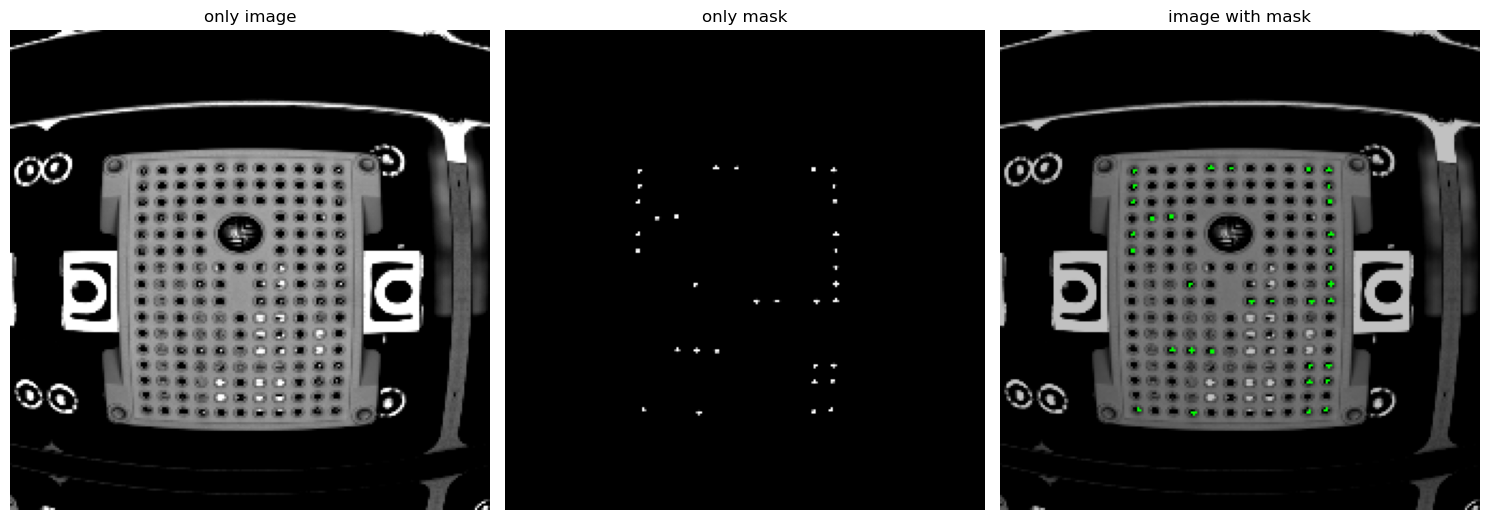

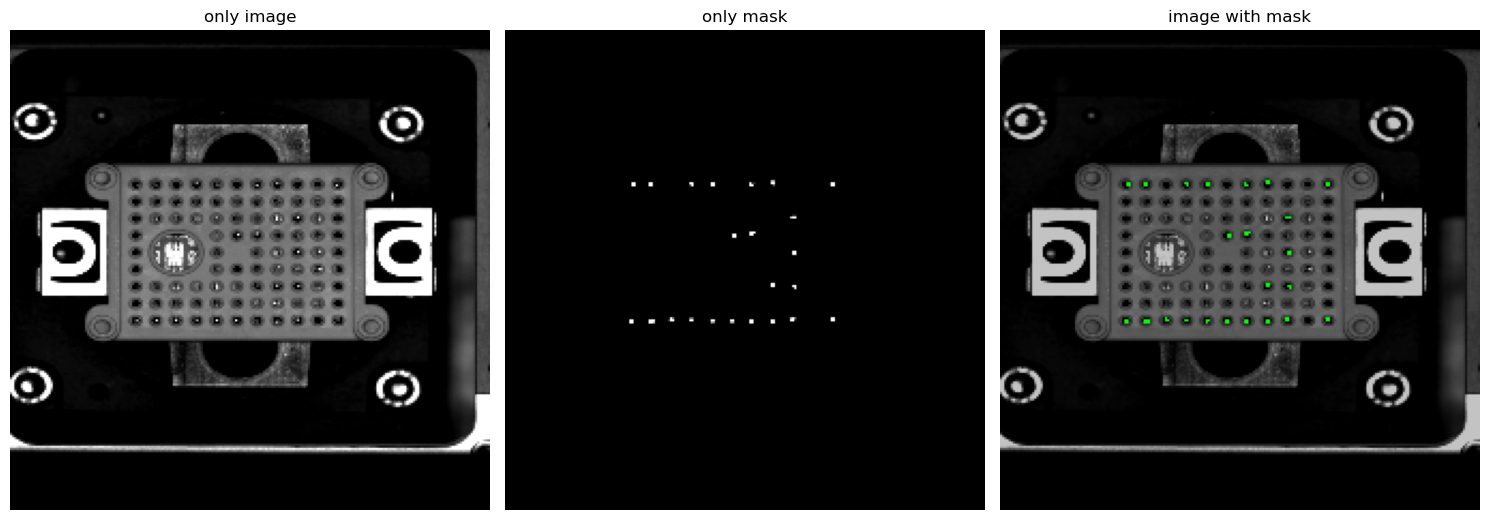

In [ ]:
preprocess_obj.display_ds(train_ds)

In [ ]:
#| export
def foo(): pass

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()